---
## 데이콘 신용카드 Missforest optuna SMOTE oversamplig, KNeightborsClassifier사용
### + random forest와 다른 oversampling도입하기 
---

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from missingpy import MissForest

In [3]:
from sklearn.metrics import *
from lightgbm import LGBMClassifier, Dataset
import optuna
from optuna.samplers import TPESampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train  = pd.read_csv('train.csv')
valid = pd.read_csv('val.csv')

---
#### 코드 잘 봤습니다. 혹시 feature 선택 기준에 대해서 공유해주실 수 있으실까요??

##### feature 선택은 validation dataset과 class의 상관관계를 확인하여 선정하였습니다
---

In [20]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28462 entries, 0 to 28461
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      28462 non-null  int64  
 1   V1      28462 non-null  float64
 2   V2      28462 non-null  float64
 3   V3      28462 non-null  float64
 4   V4      28462 non-null  float64
 5   V5      28462 non-null  float64
 6   V6      28462 non-null  float64
 7   V7      28462 non-null  float64
 8   V8      28462 non-null  float64
 9   V9      28462 non-null  float64
 10  V10     28462 non-null  float64
 11  V11     28462 non-null  float64
 12  V12     28462 non-null  float64
 13  V13     28462 non-null  float64
 14  V14     28462 non-null  float64
 15  V15     28462 non-null  float64
 16  V16     28462 non-null  float64
 17  V17     28462 non-null  float64
 18  V18     28462 non-null  float64
 19  V19     28462 non-null  float64
 20  V20     28462 non-null  float64
 21  V21     28462 non-null  float64
 22

<AxesSubplot: >

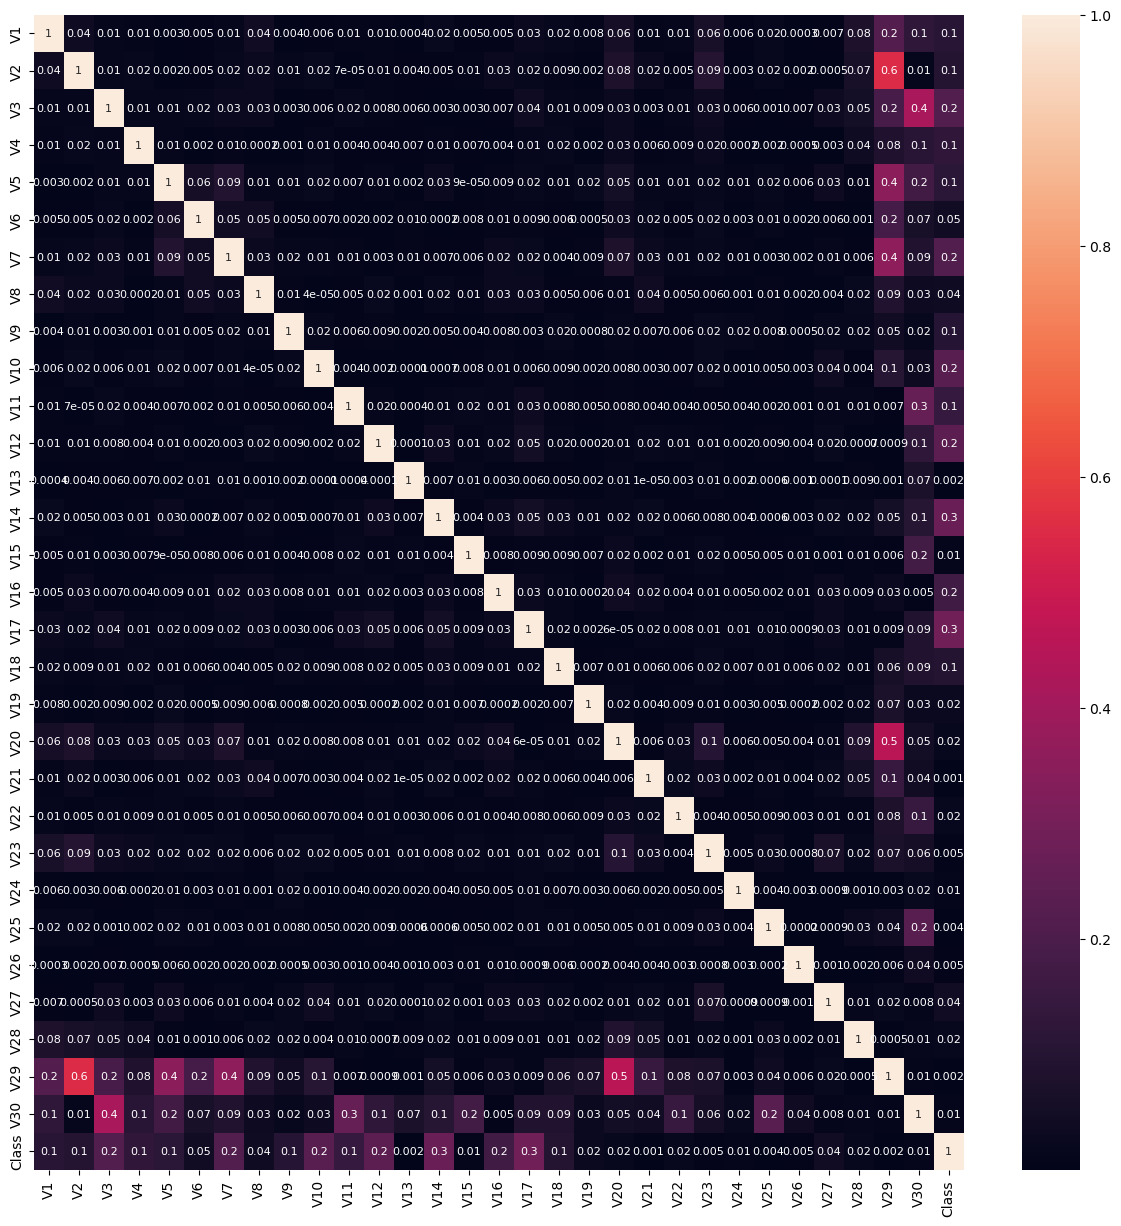

In [5]:
valid_cor = valid.drop(['ID'],axis=1).corr().abs()
plt.figure(figsize=(15,15))
#fmt는 표시되는 형식

sns.heatmap(valid_cor, annot = True, fmt = '.1g',  annot_kws={'fontsize':8})

##### 변수 선택에서 상관관계가 높은 col만을 추출한 것으로 확인됨.
##### 다중공선성이 의심되는 col의 경우(ex] v29)는 애초에 포함 X
##### 내가 사용할 상관관계가 0.2 이상 col
##### v3, v7, v10, v12, v14, 16, v17

### MissForest로 train에서 class 추가

In [18]:
train = train[['ID', 'V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
valid = valid[['ID', 'V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17', 'Class']]

<AxesSubplot: >

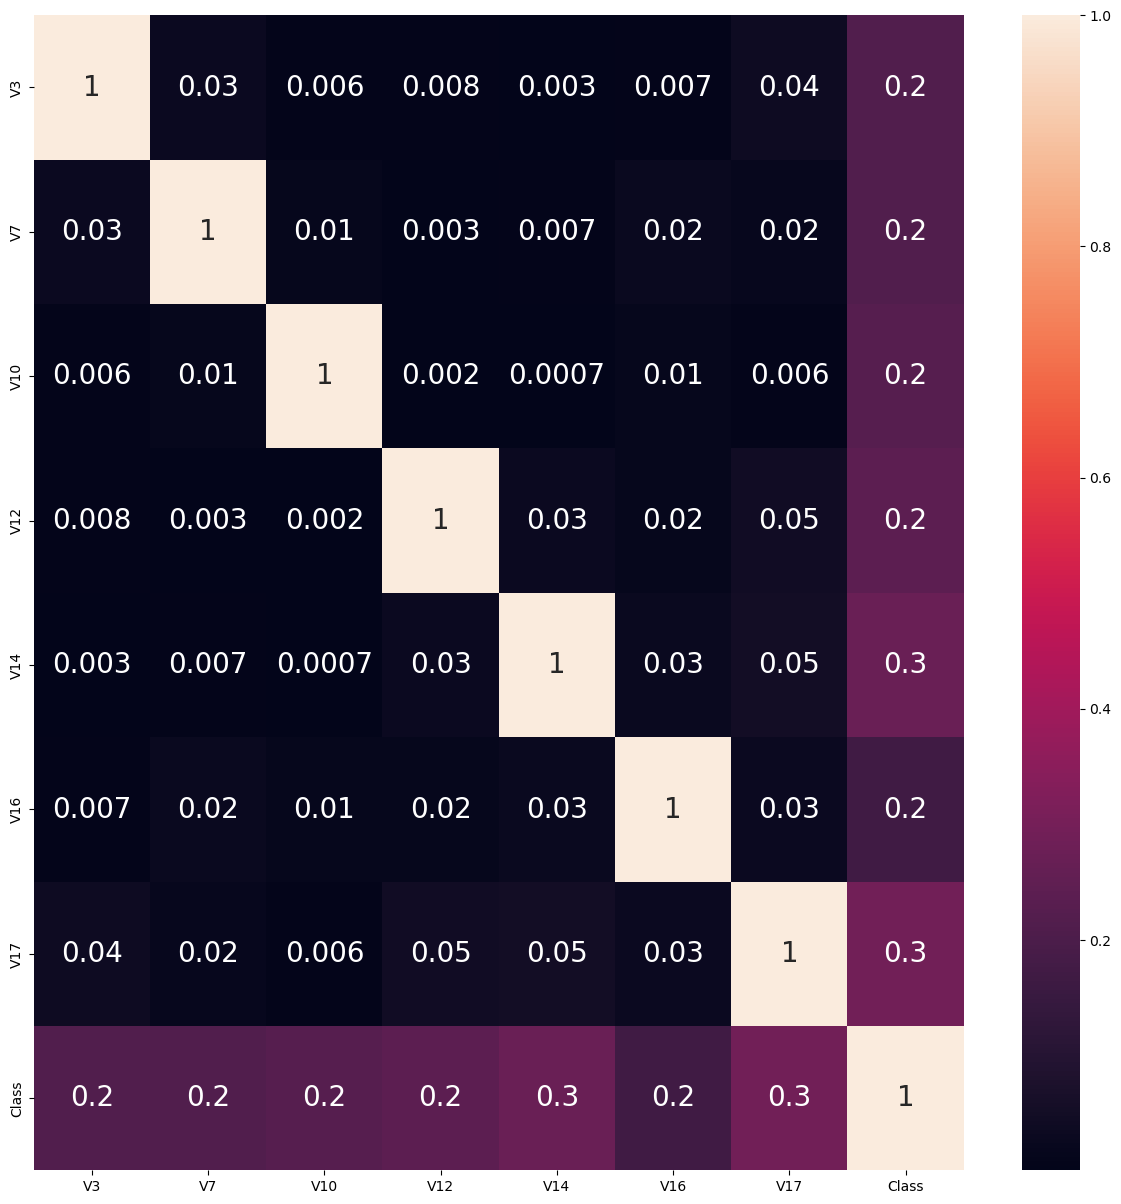

In [20]:
valid_cor = valid.drop(['ID'],axis=1).corr().abs()
plt.figure(figsize=(15,15))
#fmt는 표시되는 형식

sns.heatmap(valid_cor, annot = True, fmt = '.1g',  annot_kws={'fontsize':20})

In [21]:
# 원래 어디에 속한 데이터인지 확인하는 용도
train['data_cd'] = 'train'
valid['data_cd'] = 'valid'
df = pd.concat([train.drop(columns=['ID']), valid.drop(columns=['ID'])])

df.set_index('data_cd', drop=True, inplace=True)
df['Class'] = df['Class'].astype("category")
cat_cols = [df.columns.get_loc(col) for col in df.select_dtypes(['category']).columns.tolist()]

#### cat_cols의 의미 df에서 Missforest의 target을 정하기 위한 방법인듯 
####  df에서의 colums이 category인 컬럼을 찾아 리스트화하고 
#### 해당하는 열값을 찾기 위해 df.columns.get_loc(col) => 열의 위치를 담기! 


In [22]:
imputer = MissForest(max_iter=10, n_estimators=28462, random_state=42)
df_imputed = imputer.fit_transform(df, cat_vars=cat_cols)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)

Iteration: 0
Iteration: 1
Iteration: 2


#### df 열값을 기초로 Null값에 대한 Missforest 결측치 대체

#### train2로 X, y값 정하기

In [23]:
train2 = df_imputed[df_imputed.index=='train']
train2['ID'] = train['ID']
train2.reset_index(drop=True, inplace=True)

In [24]:
X = train2[['V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
y= train2['Class']

In [25]:
valid2 = df_imputed[df_imputed.index=='valid']
valid2['ID'] = valid['ID']
valid2.reset_index(drop=True, inplace=True)

In [27]:
from imblearn.combine import SMOTETomek

ImportError: cannot import name '_OneToOneFeatureMixin' from 'sklearn.base' (c:\Users\dddf\anaconda3\lib\site-packages\sklearn\base.py)

#### 오버샘플링

In [26]:
X_resampled, y_resampled = SMOTETomek(random_state=42).fit_resample(X, y)

ImportError: cannot import name '_OneToOneFeatureMixin' from 'sklearn.base' (c:\Users\dddf\anaconda3\lib\site-packages\sklearn\base.py)

In [ ]:
#### X_resampled['Class']를 추가함 즉, class에 대한 오버 샘플링 데이터를 X_resampled에 추가한 것임
X_resampled['Class'] = y_resampled


In [ ]:
X_train = X_resampled.drop(columns=['Class'])
X_train = X_train[['V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
y_train = X_resampled['Class']


X_valid = valid2.drop(columns=['ID', 'Class'])
X_valid = X_valid[['V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
y_valid = valid2['Class']

In [ ]:
sampler = TPESampler(seed=42)

def objective(trial):    
    params = {
        'n_neighbors':trial.suggest_int("n_neighbors", 1, 60),
        'weights': trial.suggest_categorical('weights', ["uniform", "distance"]),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size':trial.suggest_int("leaf_size", 30, 60),
        'p': trial.suggest_categorical('p', [1, 2]),
        'n_jobs': -1,
        

    }
    
    model = KNeighborsClassifier(**params)
    model.fit(X_train, y_train)
    
    y_valid_pred = model.predict(X_valid)
    return f1_score(y_valid, y_valid_pred, average="macro")

#### 학습시작

In [ ]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

In [ ]:
best_model = study.best_trial
best_params = best_model.params

print("Best model:")
print("  F1-score: {}".format(round(best_model.value, 4)))
print("  params  : {}".format(best_params))

In [ ]:
SEED = 42
patience = 50
X = X_resampled[['V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
y= X_resampled['Class']

In [ ]:
model = KNeighborsClassifier(**best_params)
model.fit(X, y)

#### 예측

In [ ]:
test = pd.read_csv(path + "test.csv")
X_test = test.drop(columns=['ID'])
X_test = X_test[['V3', 'V7', 'V10', 'V12','V14', 'V16', 'V17']]
y_test_pred = model.predict(X_test)

In [ ]:
submit = pd.read_csv("sample_submission.csv")
submit['Class'] = y_test_pred
submit.to_csv("knn_smote.csv", index=False)